Resources for analysis

* https://bioinformaticsworkbook.org/tutorials/wgcna.html#gsc.tab=0

## Set Library Path

In [3]:
.libPaths("/share/korflab/home/viki/anaconda3/jupyter_nb_R4.3/lib/R/library")

## Load Libraries

In [4]:
library(tidyverse)
library(WGCNA)
library(magrittr)
library(biomaRt)

## Load Data

In [5]:
# Read in normalized gene counts from DEG analysis
counts <- read.delim("05_gene_counts/normalized_counts.txt", row.names = 1)

# View data
head(counts)

,G1_1_1_4,G1_1_1_5,G1_1_1_6,G1_1_1_7,G1_1_2_4,G1_1_2_5,G1_1_2_6,G2_2_6_5,G2_2_6_6,G2_2_6_7,G2_2_6_8,G2_2_7_10,G2_2_7_11,G2_2_7_7,G2_2_7_8,G2_2_7_9
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000051285,5.8623556,5.8214049,5.8496721,5.8134141,5.7206892,5.333852,5.8048422,5.8525708,5.58872075,5.7749417,5.8035582,5.8083393,5.6783630,5.8486219,5.6227960,5.9566247
ENSMUSG00000103509,0.2983516,-1.5044228,-1.6538007,-1.1879393,0.8361266,-2.590010,0.4316992,0.6636771,-0.08022876,0.8915903,0.2430641,-1.9766896,-0.5350123,0.2614967,-2.5900101,-0.5017600
ENSMUSG00000097797,0.9140247,0.6452259,0.3829039,0.6767366,1.0008217,1.045641,1.2532123,0.5208986,0.19012609,0.5571165,0.2430641,0.3894827,0.7976682,0.5789491,0.4848330,0.2096132
ENSMUSG00000026312,3.3547184,3.7034065,3.7728273,3.3300863,3.8815256,4.056796,3.6704622,3.5434458,5.03226389,4.0190677,3.4439909,4.6013811,4.1602418,2.9007806,3.8144665,3.2926257
ENSMUSG00000039748,0.3912817,0.8076605,1.0965376,0.7948876,1.2826872,1.573093,0.8418504,1.9900025,1.58156492,1.0063180,1.3058155,0.0648287,0.7079450,1.4582125,0.6992561,0.8371884
ENSMUSG00000057363,4.5333998,4.7993203,4.7437552,4.7313907,5.0529841,5.965852,5.1824331,4.6831706,4.71645089,4.6374297,4.4054985,4.0317310,4.2344181,4.5843911,4.4241977,4.4797900


## Confirm Data Normalization

In [6]:
# Convert row names to a column
counts$GeneId <- rownames(counts)

# Reset row names
rownames(counts) <- NULL

# Reorder columns so that "GeneId" is the first column
counts <- counts[, c("GeneId", names(counts)[-ncol(counts)])]

# View
head(counts)

,GeneId,G1_1_1_4,G1_1_1_5,G1_1_1_6,G1_1_1_7,G1_1_2_4,G1_1_2_5,G1_1_2_6,G2_2_6_5,G2_2_6_6,G2_2_6_7,G2_2_6_8,G2_2_7_10,G2_2_7_11,G2_2_7_7,G2_2_7_8,G2_2_7_9
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSMUSG00000051285,5.8623556,5.8214049,5.8496721,5.8134141,5.7206892,5.333852,5.8048422,5.8525708,5.58872075,5.7749417,5.8035582,5.8083393,5.6783630,5.8486219,5.6227960,5.9566247
2,ENSMUSG00000103509,0.2983516,-1.5044228,-1.6538007,-1.1879393,0.8361266,-2.590010,0.4316992,0.6636771,-0.08022876,0.8915903,0.2430641,-1.9766896,-0.5350123,0.2614967,-2.5900101,-0.5017600
3,ENSMUSG00000097797,0.9140247,0.6452259,0.3829039,0.6767366,1.0008217,1.045641,1.2532123,0.5208986,0.19012609,0.5571165,0.2430641,0.3894827,0.7976682,0.5789491,0.4848330,0.2096132
4,ENSMUSG00000026312,3.3547184,3.7034065,3.7728273,3.3300863,3.8815256,4.056796,3.6704622,3.5434458,5.03226389,4.0190677,3.4439909,4.6013811,4.1602418,2.9007806,3.8144665,3.2926257
5,ENSMUSG00000039748,0.3912817,0.8076605,1.0965376,0.7948876,1.2826872,1.573093,0.8418504,1.9900025,1.58156492,1.0063180,1.3058155,0.0648287,0.7079450,1.4582125,0.6992561,0.8371884
6,ENSMUSG00000057363,4.5333998,4.7993203,4.7437552,4.7313907,5.0529841,5.965852,5.1824331,4.6831706,4.71645089,4.6374297,4.4054985,4.0317310,4.2344181,4.5843911,4.4241977,4.4797900


In [7]:
# Transpose the dataframe into longer format

# Get all but first column name
col_sel <- names(counts)[-1]     

# Transpose
mdata <- counts %>%
  pivot_longer(
    cols = col_sel,
    names_to = "name",
    values_to = "value"
  ) %>%  
  mutate(
    group = substr(name, 1, 2)
  )

# View 
head(mdata)

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(col_sel)

  # Now:
  data %>% select(all_of(col_sel))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


GeneId,name,value,group
<chr>,<chr>,<dbl>,<chr>
ENSMUSG00000051285,G1_1_1_4,5.862356,G1
ENSMUSG00000051285,G1_1_1_5,5.821405,G1
ENSMUSG00000051285,G1_1_1_6,5.849672,G1
ENSMUSG00000051285,G1_1_1_7,5.813414,G1
ENSMUSG00000051285,G1_1_2_4,5.720689,G1
ENSMUSG00000051285,G1_1_2_5,5.333852,G1


In [9]:
# Order groups for plot
mdata$group <- factor(mdata$group,
                      levels = c("G1", "G2"))

pdf("06_WGCNA/fae_vs_control_normalized_expression_violin_plots.pdf", height = 10, width = 10)

# Plot groups (Sample Groups vs RNA Seq Counts) to identify outliers
p <- mdata %>%
    ggplot(aes(x = name, y = value)) +             
    geom_violin() +                                   
    geom_point(alpha = 0.2) +                       
    theme_bw() +
    theme(
      axis.text.x = element_text(angle = 90)          
    ) +
    labs(x = "Treatment Groups", y = "Normalized RNA Seq Counts") +
    facet_grid(cols = vars(group), drop = TRUE, scales = "free_x")

p

dev.off()

png 
  2

## WGCNA

### Read in Count Data

In [10]:
# Read in normalized gene counts from DEG analysis
counts <- read.delim("05_gene_counts/normalized_counts.txt", row.names = 1)

# View data
head(counts)

,G1_1_1_4,G1_1_1_5,G1_1_1_6,G1_1_1_7,G1_1_2_4,G1_1_2_5,G1_1_2_6,G2_2_6_5,G2_2_6_6,G2_2_6_7,G2_2_6_8,G2_2_7_10,G2_2_7_11,G2_2_7_7,G2_2_7_8,G2_2_7_9
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000051285,5.8623556,5.8214049,5.8496721,5.8134141,5.7206892,5.333852,5.8048422,5.8525708,5.58872075,5.7749417,5.8035582,5.8083393,5.6783630,5.8486219,5.6227960,5.9566247
ENSMUSG00000103509,0.2983516,-1.5044228,-1.6538007,-1.1879393,0.8361266,-2.590010,0.4316992,0.6636771,-0.08022876,0.8915903,0.2430641,-1.9766896,-0.5350123,0.2614967,-2.5900101,-0.5017600
ENSMUSG00000097797,0.9140247,0.6452259,0.3829039,0.6767366,1.0008217,1.045641,1.2532123,0.5208986,0.19012609,0.5571165,0.2430641,0.3894827,0.7976682,0.5789491,0.4848330,0.2096132
ENSMUSG00000026312,3.3547184,3.7034065,3.7728273,3.3300863,3.8815256,4.056796,3.6704622,3.5434458,5.03226389,4.0190677,3.4439909,4.6013811,4.1602418,2.9007806,3.8144665,3.2926257
ENSMUSG00000039748,0.3912817,0.8076605,1.0965376,0.7948876,1.2826872,1.573093,0.8418504,1.9900025,1.58156492,1.0063180,1.3058155,0.0648287,0.7079450,1.4582125,0.6992561,0.8371884
ENSMUSG00000057363,4.5333998,4.7993203,4.7437552,4.7313907,5.0529841,5.965852,5.1824331,4.6831706,4.71645089,4.6374297,4.4054985,4.0317310,4.2344181,4.5843911,4.4241977,4.4797900


In [11]:
# Transpose for WGCNA
counts <- t(counts)

head(counts)

,ENSMUSG00000051285,ENSMUSG00000103509,ENSMUSG00000097797,ENSMUSG00000026312,ENSMUSG00000039748,ENSMUSG00000057363,ENSMUSG00000038702,ENSMUSG00000100515,ENSMUSG00000033021,ENSMUSG00000055214,⋯,ENSMUSG00000064358,ENSMUSG00000064363,ENSMUSG00000064367,ENSMUSG00000064368,ENSMUSG00000064369,ENSMUSG00000064370,ENSMUSG00000064371,ENSMUSG00000064372,ENSMUSG00000095041,ENSMUSG00000095742
G1_1_1_4,5.862356,0.2983516,0.9140247,3.354718,0.3912817,4.533400,4.109893,0.4785863,4.973664,-1.280884296,⋯,2.455322,9.651863,10.501845,8.684080,4.143676,11.11571,0.638784397,4.411123,7.471423,3.307809
G1_1_1_5,5.821405,-1.5044228,0.6452259,3.703406,0.8076605,4.799320,3.923169,0.3610993,4.558121,0.006943263,⋯,2.741923,9.487347,10.152474,8.187756,3.850465,10.87664,0.006943263,4.289118,6.834680,3.887275
G1_1_1_6,5.849672,-1.6538007,0.3829039,3.772827,1.0965376,4.743755,3.953221,-0.6867860,4.780057,-0.520572975,⋯,2.190894,9.506349,10.308329,8.272462,4.001851,10.86935,0.614982823,4.138615,6.718446,4.430166
G1_1_1_7,5.813414,-1.1879393,0.6767366,3.330086,0.7948876,4.731391,3.986835,0.7948876,4.879151,0.164839516,⋯,2.559694,9.565131,10.102755,8.323810,3.903801,10.88876,1.189433525,4.663118,7.068253,4.226472
G1_1_2_4,5.720689,0.8361266,1.0008217,3.881526,1.2826872,5.052984,4.219136,-0.2973407,4.751480,0.185973359,⋯,2.199061,9.168697,9.780332,7.847393,3.223632,10.56855,0.920823063,4.443273,6.989919,3.943569
G1_1_2_5,5.333852,-2.5900101,1.0456410,4.056796,1.5730927,5.965852,4.259127,-0.2354227,4.304182,0.542861937,⋯,2.239325,8.702100,9.145384,7.705564,2.284993,10.30368,1.333338408,4.960914,6.591600,4.585411


### Set Up Metadata

In [12]:
# Extract sample names and initialize data frame with conditions
samples <- as.character(rownames(counts))
metadata <- data.frame(samples)
metadata$Control_vs_FA <- c(0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1)
metadata$Treatment <- c("Control", "Control", "Control", "Control", "Control", "Control", "Control", "FA", "FA", "FA", "FA", "FA", "FA", "FA", "FA", "FA")
metadata$Sex <- c("Female", "Female", "Male", "Male", "Male", "Female", "Female", "Female", "Female", "Female", "Female", "Female", "Male", "Male", "Male", "Female")
metadata$Male <- c(0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0)
metadata$Female <- c(1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1)

# Initialize columns for pairwise comparisons
metadata$ControlFemale_vs_FAFemale <- NA
metadata$ControlMale_vs_FAMale <- NA
metadata$FAFemale_vs_FAMale <- NA
metadata$ControlFemale_vs_ControlMale <- NA
metadata$Litter <- NA

# Assign values for ControlFemale_vs_FAFemale
metadata$ControlFemale_vs_FAFemale[metadata$Treatment == "Control" & metadata$Sex == "Female"] <- 0
metadata$ControlFemale_vs_FAFemale[metadata$Treatment == "FA" & metadata$Sex == "Female"] <- 1

# Assign values for ControlMale_vs_FAMale
metadata$ControlMale_vs_FAMale[metadata$Treatment == "Control" & metadata$Sex == "Male"] <- 0
metadata$ControlMale_vs_FAMale[metadata$Treatment == "FA" & metadata$Sex == "Male"] <- 1

# Assign values for FAFemale_vs_FAMale
metadata$FAFemale_vs_FAMale[metadata$Treatment == "FA" & metadata$Sex == "Female"] <- 0
metadata$FAFemale_vs_FAMale[metadata$Treatment == "FA" & metadata$Sex == "Male"] <- 1

# Assign values for ControlFemale_vs_ControlMale
metadata$ControlFemale_vs_ControlMale[metadata$Treatment == "Control" & metadata$Sex == "Female"] <- 0
metadata$ControlFemale_vs_ControlMale[metadata$Treatment == "Control" & metadata$Sex == "Male"] <- 1

# Set row names
row.names(metadata) <- metadata$samples

# Assign values for litter
litter <- sapply(strsplit(rownames(metadata), "_"), function(x) x[3])
metadata$Litter[litter == "1"] <- 0
metadata$Litter[litter == "2"] <- 1
metadata$Litter[litter == "6"] <- 2
metadata$Litter[litter == "7"] <- 3

# Delete residual column
metadata$samples <- NULL

metadata

,Control_vs_FA,Treatment,Sex,Male,Female,ControlFemale_vs_FAFemale,ControlMale_vs_FAMale,FAFemale_vs_FAMale,ControlFemale_vs_ControlMale,Litter
,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
G1_1_1_4,0,Control,Female,0,1,0,NA,NA,0,0
G1_1_1_5,0,Control,Female,0,1,0,NA,NA,0,0
G1_1_1_6,0,Control,Male,1,0,NA,0,NA,1,0
G1_1_1_7,0,Control,Male,1,0,NA,0,NA,1,0
G1_1_2_4,0,Control,Male,1,0,NA,0,NA,1,1
G1_1_2_5,0,Control,Female,0,1,0,NA,NA,0,1
G1_1_2_6,0,Control,Female,0,1,0,NA,NA,0,1
G2_2_6_5,1,FA,Female,0,1,1,NA,0,NA,2
G2_2_6_6,1,FA,Female,0,1,1,NA,0,NA,2


### Soft Power Threshold

In [13]:
# Allow multi-threading
allowWGCNAThreads() 

# Choose a set of soft-thresholding powers
powers = c(c(1:10), seq(from = 12, to = 25, by = 1))

# Call the network topology analysis function
sft = pickSoftThreshold(
  counts,             
  #blockSize = 30,
  powerVector = powers,
  verbose = 5,
  networkType = "signed",
  )

Allowing multi-threading with up to 256 threads.
pickSoftThreshold: will use block size 2651.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 2651 of 16875
   ..working on genes 2652 through 5302 of 16875
   ..working on genes 5303 through 7953 of 16875
   ..working on genes 7954 through 10604 of 16875
   ..working on genes 10605 through 13255 of 16875
   ..working on genes 13256 through 15906 of 16875
   ..working on genes 15907 through 16875 of 16875
   Power SFT.R.sq   slope truncated.R.sq mean.k. median.k. max.k.
1      1 0.004850  5.3900          0.934  8450.0    8450.0   8710
2      2 0.070000  4.1300          0.921  4850.0    4840.0   5490
3      3 0.027100  1.0300          0.861  3050.0    3030.0   3950
4      4 0.000235  0.0514          0.861  2050.0    2020.0   3040
5      5 0.024600 -0.3490          0.877  1450.0    1410.0   2430
6      6 0.109000 -0.5610          0.900  1060.0    1020.0   2010
7      7 0.234000 -0.7080       

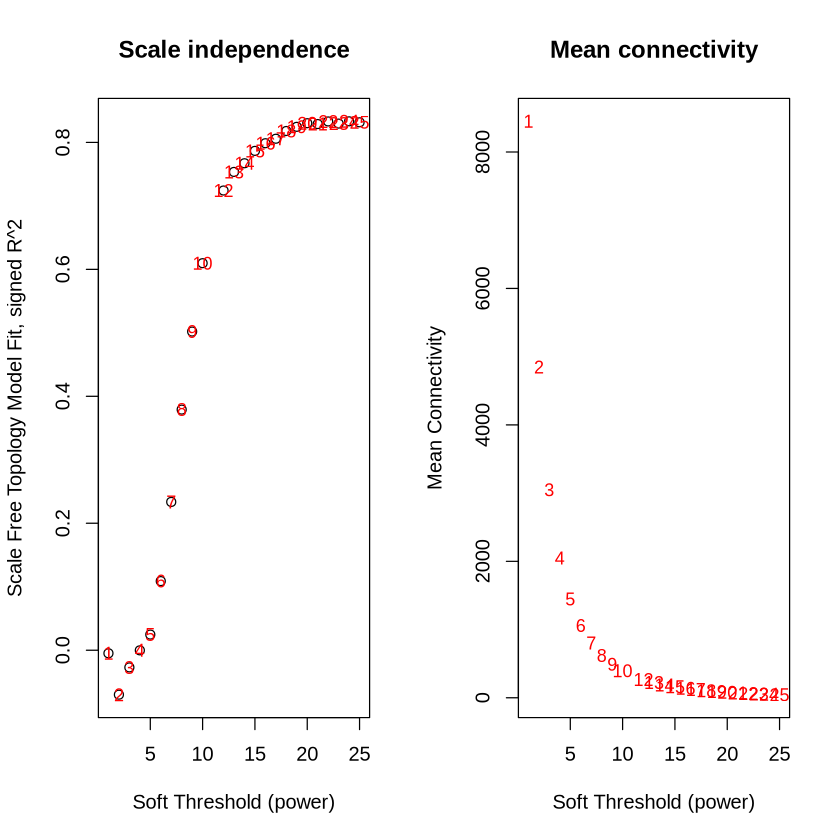

In [14]:
# Plot soft power thresholds

par(mfrow = c(1,2));
cex1 = 0.9;

plot(sft$fitIndices[, 1],
     -sign(sft$fitIndices[, 3]) * sft$fitIndices[, 2],
     xlab = "Soft Threshold (power)",
     ylab = "Scale Free Topology Model Fit, signed R^2",
     main = paste("Scale independence")
)
text(sft$fitIndices[, 1],
     -sign(sft$fitIndices[, 3]) * sft$fitIndices[, 2],
     labels = powers, cex = cex1, col = "red"
)
abline(h = 0.90, col = "red")
plot(sft$fitIndices[, 1],
     sft$fitIndices[, 5],
     xlab = "Soft Threshold (power)",
     ylab = "Mean Connectivity",
     type = "n",
     main = paste("Mean connectivity")
)
text(sft$fitIndices[, 1],
     sft$fitIndices[, 5],
     labels = powers,
     cex = cex1, col = "red")

### Module Generation

Pick a soft threshold power where the SFT.R.sq is above 0.8. Looking at the output of sft, we see that this is 17.

In [15]:
# Build Modules

picked_power = 17
temp_cor <- cor       
cor <- WGCNA::cor # Force it to use WGCNA cor function (fix a namespace conflict issue)

netwk <- blockwiseModules(counts,

                          # Other options
                          maxPOutliers = 0.1,
                          TOMType = "signed",
                          networkCalibration = "full quantile",
                          saveConsensusTOMs = TRUE,

                          # == Adjacency Function ==
                          power = picked_power,                
                          networkType = "signed",

                          # == Tree and Block Options ==
                          deepSplit = 3,
                          pamRespectsDendro = F,
                          # detectCutHeight = 0.75,
                          minModuleSize = 30, # Affects network generation (minimum genes per module, can increase to decrease modules or vice versa)
                          maxBlockSize = 4000, # Primarily to control RAM usage

                          # == Module Adjustments ==
                          reassignThreshold = 0,
                          mergeCutHeight = 0.25,

                          # == TOM == Archive the run results in TOM file (saves time)
                          saveTOMs = T,
                          saveTOMFileBase = "ER",

                          # == Output Options
                          numericLabels = T,
                          verbose = 3)

cor <- temp_cor # Return cor function to original namespace

 Calculating module eigengenes block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
 ....pre-clustering genes to determine blocks..
   Projective K-means:
   ..k-means clustering..
   ..merging smaller clusters...
Block sizes:
gBlocks
   1    2    3    4    5 
3992 3947 3776 2660 2500 
 ..Working on block 1 .
    TOM calculation: adjacency..
    ..will use 128 parallel threads.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
   ..saving TOM for block 1 into file ER-block.1.RData
 ....clustering..
 ....detecting modules..
 ....calculating module eigengenes..
 ....checking kME in modules..
     ..removing 9 genes from module 1 because their KME is too low.
     ..removing 7 genes from module 2 because their KME is too low.
     ..removing 4 genes from module 3 because their KME is too low.
     ..removing 2 genes from module 4 because their KME i

In [16]:
# Convert numeric module labels to module colors
mergedColors = labels2colors(netwk$colors)

# View module distribution as a table (number of genes per module)
module_dist <- as.data.frame(table(mergedColors) %>% sort(decreasing = TRUE))
colnames(module_dist) <- c("Module", "Genes")
head(module_dist)

# Number of modules
length(rownames(module_dist))

# Save output
write.csv(module_dist,"06_WGCNA/gene_module_distribution.csv")

,Module,Genes
,<fct>,<int>
1,turquoise,3464
2,blue,2163
3,brown,1548
4,yellow,1238
5,green,1142
6,red,1009


[1] 46

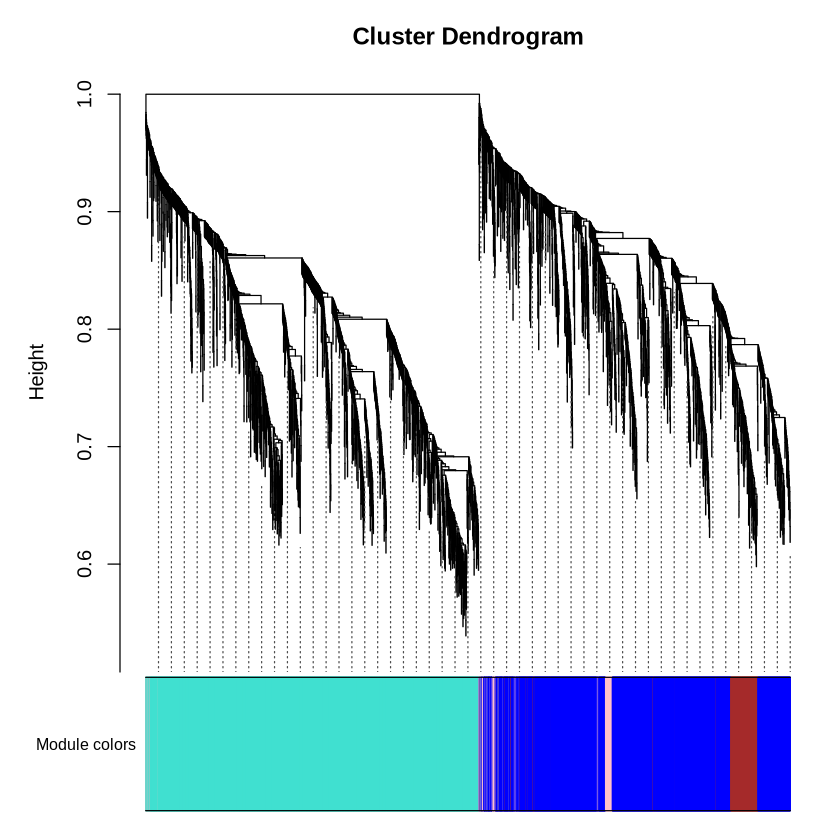

In [17]:
# Plot the dendrogram and the module colors underneath
plotDendroAndColors(
  netwk$dendrograms[[1]],
  mergedColors[netwk$blockGenes[[1]]],
  "Module colors",
  dendroLabels = FALSE,
  hang = 0.03,
  addGuide = TRUE,
  guideHang = 0.05 )

In [18]:
# Pull out list of modules
module_df <- data.frame(
  gene_id = names(netwk$colors),
  colors = labels2colors(netwk$colors)
)

head(module_df)

,gene_id,colors
,<chr>,<chr>
1,ENSMUSG00000051285,blue
2,ENSMUSG00000103509,pink
3,ENSMUSG00000097797,turquoise
4,ENSMUSG00000026312,red
5,ENSMUSG00000039748,yellow
6,ENSMUSG00000057363,turquoise


In [19]:
# Save modules
write_delim(module_df, file = "06_WGCNA/gene_modules.txt", delim = "\t")

### Module Eigengenes

In [20]:
# Get Module Eigengenes per cluster
MEs0 <- moduleEigengenes(counts, mergedColors)$eigengenes

# Reorder modules so similar modules are next to each other
MEs0 <- orderMEs(MEs0)
module_order = names(MEs0) %>% gsub("ME","", .)

# Add treatment names
MEs0$treatment = row.names(MEs0)

head(MEs0)

,MEgreen,MEpurple,MEdarkgrey,MEfloralwhite,MEdarkmagenta,MEdarkorange2,MEsteelblue,MElightgreen,MElightsteelblue1,MEturquoise,⋯,MEyellowgreen,MEblack,MEmagenta,MEroyalblue,MElightyellow,MEred,MEcyan,MEmidnightblue,MEgrey,treatment
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
G1_1_1_4,0.15568369,0.41752206,0.23941698,0.3667297,-0.16772500,0.09375082,-0.0009989123,0.092767766,-0.39738174,-0.190769457,⋯,0.15096493,-0.079667262,0.3139518,0.05381229,-0.38213644,-0.162464412,0.19453170,0.04052584,0.01330113,G1_1_1_4
G1_1_1_5,-0.03670908,0.07496884,0.25109152,0.2644314,0.02491623,0.05658314,0.0875280691,0.074491151,0.26895344,0.048382119,⋯,-0.28771155,-0.002958318,0.1419044,0.20117813,-0.09190065,0.062806170,0.04286422,0.19608904,0.12611891,G1_1_1_5
G1_1_1_6,0.10073683,0.24325523,0.23507306,0.4009151,0.05974552,0.08904249,0.0820812838,-0.000858454,0.09655638,-0.002337422,⋯,-0.18115126,-0.057034907,0.1875141,0.33678999,-0.22961638,-0.070557767,-0.08105076,0.27324250,0.05509307,G1_1_1_6
G1_1_1_7,-0.02367512,0.18221097,0.23718401,0.3089127,-0.01867639,0.10597797,0.1535541522,0.149335998,0.20511398,0.101084179,⋯,-0.08576855,-0.095328703,0.2148757,0.07100586,-0.22241752,0.008885377,0.15229759,0.13706647,0.11510890,G1_1_1_7
G1_1_2_4,0.01840382,-0.03320727,0.13724856,-0.2483095,-0.36133018,-0.20843227,-0.5240264109,0.121641958,-0.12013323,0.206082225,⋯,-0.06548800,-0.122788802,-0.1338927,-0.31867224,0.15052342,0.033065068,0.24691169,0.10312393,0.04257365,G1_1_2_4
G1_1_2_5,-0.12553487,-0.02579178,0.01795843,-0.3710551,-0.12457701,-0.09543870,0.3601818301,0.326307137,0.42344956,0.781347751,⋯,-0.15006188,-0.302628707,-0.4924188,-0.39508383,0.45506470,0.250428151,0.14969512,0.13616860,-0.18488948,G1_1_2_5


In [21]:
# Calculate module membership
moduleMembership <- bicorAndPvalue(counts, MEs0,
                                  alternative = "two.sided", use = "pairwise.complete.obs",
                                  maxPOutliers = 0.1)

Warning message in storage.mode(y) <- "double":
“NAs introduced by coercion”


In [22]:
# Generate module membership files
MM <- as.data.frame(moduleMembership$bicor)
colnames(MM) <- gsub(pattern = "ME", replacement = "", x = colnames(MM), fixed = TRUE)
MM$Probe <- rownames(MM)
MM$Module <- mergedColors

# View
head(MM)

,green,purple,darkgrey,floralwhite,darkmagenta,darkorange2,steelblue,lightgreen,lightsteelblue1,turquoise,⋯,magenta,royalblue,lightyellow,red,cyan,midnightblue,grey,treatment,Probe,Module
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
ENSMUSG00000051285,0.59686605,0.5384863,0.02348710,0.29256983,0.2631653,0.22040409,0.36730416,0.3873096,-0.15076864,-0.1683200,⋯,-0.160475269,-0.03494214,-0.436209134,-0.6101877,-0.45347995,-0.1040824,-0.1231210,NA,ENSMUSG00000051285,blue
ENSMUSG00000103509,0.42837595,0.1083171,-0.08741017,0.02449209,-0.1362908,-0.41168084,-0.65490756,-0.2893695,-0.76853704,-0.1353350,⋯,-0.284145377,-0.24967969,-0.104928381,-0.4138838,-0.18533838,-0.1181824,0.1920828,NA,ENSMUSG00000103509,pink
ENSMUSG00000097797,-0.07508412,0.2391398,0.29724913,0.07691840,-0.5737005,-0.08359813,-0.01709995,0.3117037,0.04116955,0.6151102,⋯,-0.005949259,-0.48923655,0.113688673,0.1216724,0.49222088,0.1192299,-0.3362638,NA,ENSMUSG00000097797,turquoise
ENSMUSG00000026312,-0.84428769,-0.8026044,-0.36789832,-0.55987401,-0.4797029,-0.50930552,-0.32370115,-0.3787861,0.10231679,0.0742103,⋯,0.100457985,0.29146024,0.828026714,0.8905114,0.48429015,0.3927852,-0.1909889,NA,ENSMUSG00000026312,red
ENSMUSG00000039748,0.37857369,-0.0385568,0.05027755,-0.05189153,0.3177974,-0.31419284,-0.10911551,-0.1400459,0.01006856,0.3536468,⋯,-0.729785177,-0.54760844,0.214707852,-0.2386346,-0.56246424,-0.2159093,0.2868518,NA,ENSMUSG00000039748,yellow
ENSMUSG00000057363,0.24008077,0.3494470,0.55889230,0.25063595,-0.2476607,-0.39661770,-0.19477747,0.2534035,0.11886470,0.8205615,⋯,-0.410404664,-0.34662745,0.005880216,-0.1371563,-0.02012404,0.4384724,0.3061625,NA,ENSMUSG00000057363,turquoise


### Convert Ensemble Gene IDs to Gene Names

In [23]:
# Select Ensembl database
ensembl <- useEnsembl(biomart = "genes", dataset = "mmusculus_gene_ensembl")

In [24]:
# Start by converting to Entrez Gene IDs
lookup <- getBM(
  mart = ensembl,
  attributes = c('ensembl_gene_id', 'entrezgene_id'),
  filter = 'ensembl_gene_id',
  values = MM$Probe,
  uniqueRows = TRUE)

head(lookup)

,ensembl_gene_id,entrezgene_id
,<chr>,<int>
1,ENSMUSG00000000049,11818
2,ENSMUSG00000000056,67608
3,ENSMUSG00000000088,12858
4,ENSMUSG00000000127,14158
5,ENSMUSG00000000194,277463
6,ENSMUSG00000000202,72014


In [25]:
# Add Entrez IDs to table

# Merge the lookup dataframe with the control_vs_faexcess dataframe based on the Ensembl gene IDs
MM <- merge(MM, lookup, by.x = "Probe", by.y = "ensembl_gene_id", all.x = TRUE)

# Rename the column to entrez_gene_id
names(MM)[names(MM) == "entrezgene_id"] <- "entrez_gene_id"

# View the updated dataframe
head(MM)

,Probe,green,purple,darkgrey,floralwhite,darkmagenta,darkorange2,steelblue,lightgreen,lightsteelblue1,⋯,magenta,royalblue,lightyellow,red,cyan,midnightblue,grey,treatment,Module,entrez_gene_id
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
1,ENSMUSG00000000001,0.53142578,0.319054961,0.09441111,0.17026045,0.56879173,0.17024136,0.56362065,0.40996143,0.33985973,⋯,-0.6535102,-0.43415736,-0.13178895,-0.49889088,-0.7366948,-0.2444481,0.21113112,NA,darkturquoise,14679
2,ENSMUSG00000000028,0.60286963,0.001076259,-0.20567613,-0.21333172,0.36991102,-0.25185972,-0.19855241,-0.12488154,-0.33269158,⋯,-0.7601201,-0.53578706,0.07207819,-0.50864414,-0.6742956,-0.4225157,0.12412939,NA,green,12544
3,ENSMUSG00000000031,-0.56823447,-0.371424292,-0.15641282,-0.02060351,-0.13964062,-0.12241386,-0.17642277,-0.47723936,0.05839258,⋯,0.5709149,0.92420016,0.11543744,0.54617147,0.3178056,0.4676651,-0.05378321,NA,royalblue,14955
4,ENSMUSG00000000037,-0.19368906,-0.050444428,-0.08844034,0.08340248,-0.05129436,0.41736770,0.04044405,-0.01045664,-0.03456155,⋯,0.5073228,0.28891655,-0.25478470,0.04349390,0.2439955,-0.1895834,-0.09170282,NA,blue,107815
5,ENSMUSG00000000049,0.02317175,-0.312096920,-0.43382664,-0.13326823,0.25839775,0.01139912,-0.28451796,-0.74208287,-0.36940677,⋯,0.2017751,0.07591392,0.01130970,-0.06507401,-0.1504348,-0.4146887,0.26865218,NA,blue,11818
6,ENSMUSG00000000056,-0.08285896,-0.522418637,-0.67198767,-0.57763420,0.38722027,0.28926086,0.12705343,-0.19322065,0.01120284,⋯,-0.1188867,-0.13355367,0.19881728,-0.02434180,-0.2208846,-0.6033503,-0.03792721,NA,greenyellow,67608


In [26]:
# Do another lookup for External Gene Names to ensure as many Ensembl genes are converted as possible
lookup <- getBM(
  mart = ensembl,
  attributes = c('ensembl_gene_id', 'external_gene_name'),
  filter = 'ensembl_gene_id',
  values = MM$Probe,
  uniqueRows = TRUE)

names(lookup)[names(lookup) == "ensembl_gene_id"] <- "gene_names"

head(lookup)

,gene_names,external_gene_name
,<chr>,<chr>
1,ENSMUSG00000000001,Gnai3
2,ENSMUSG00000000028,Cdc45
3,ENSMUSG00000000031,H19
4,ENSMUSG00000000037,Scml2
5,ENSMUSG00000000049,Apoh
6,ENSMUSG00000000056,Narf


In [27]:
# Add Gene Names to dataframe

# Merge the lookup dataframe with the control_vs_faexcess dataframe based on the Ensembl gene IDs
MM <- merge(MM, lookup, by.x = "Probe", by.y = "gene_names", all.x = TRUE)

# View the updated dataframe
head(MM)

,Probe,green,purple,darkgrey,floralwhite,darkmagenta,darkorange2,steelblue,lightgreen,lightsteelblue1,⋯,royalblue,lightyellow,red,cyan,midnightblue,grey,treatment,Module,entrez_gene_id,external_gene_name
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>
1,ENSMUSG00000000001,0.53142578,0.319054961,0.09441111,0.17026045,0.56879173,0.17024136,0.56362065,0.40996143,0.33985973,⋯,-0.43415736,-0.13178895,-0.49889088,-0.7366948,-0.2444481,0.21113112,NA,darkturquoise,14679,Gnai3
2,ENSMUSG00000000028,0.60286963,0.001076259,-0.20567613,-0.21333172,0.36991102,-0.25185972,-0.19855241,-0.12488154,-0.33269158,⋯,-0.53578706,0.07207819,-0.50864414,-0.6742956,-0.4225157,0.12412939,NA,green,12544,Cdc45
3,ENSMUSG00000000031,-0.56823447,-0.371424292,-0.15641282,-0.02060351,-0.13964062,-0.12241386,-0.17642277,-0.47723936,0.05839258,⋯,0.92420016,0.11543744,0.54617147,0.3178056,0.4676651,-0.05378321,NA,royalblue,14955,H19
4,ENSMUSG00000000037,-0.19368906,-0.050444428,-0.08844034,0.08340248,-0.05129436,0.41736770,0.04044405,-0.01045664,-0.03456155,⋯,0.28891655,-0.25478470,0.04349390,0.2439955,-0.1895834,-0.09170282,NA,blue,107815,Scml2
5,ENSMUSG00000000049,0.02317175,-0.312096920,-0.43382664,-0.13326823,0.25839775,0.01139912,-0.28451796,-0.74208287,-0.36940677,⋯,0.07591392,0.01130970,-0.06507401,-0.1504348,-0.4146887,0.26865218,NA,blue,11818,Apoh
6,ENSMUSG00000000056,-0.08285896,-0.522418637,-0.67198767,-0.57763420,0.38722027,0.28926086,0.12705343,-0.19322065,0.01120284,⋯,-0.13355367,0.19881728,-0.02434180,-0.2208846,-0.6033503,-0.03792721,NA,greenyellow,67608,Narf


In [28]:
# Save
write.table(MM, "06_WGCNA/module_membership.txt", sep = "\t", quote = FALSE, row.names = FALSE)

### Get Module Hub Genes

In [29]:
# Get module hub genes
hubGenes <- sapply(colnames(MM)[!colnames(MM) %in% c("Probe", "treatment", "Module", "entrez_gene_id", "external_gene_name")], function(x){
  temp <- MM[MM$Module == x,]
  temp$external_gene_name[temp[, x] == max(temp[, x])] %>% as.character %>% unique %>% sort})

# View
head(hubGenes)

# Save data
write.csv(hubGenes, "06_WGCNA/hubGenes.csv")

green      purple    darkgrey floralwhite darkmagenta darkorange2 
  "Cttnbp2"     "Acap3"      "Nrgn"     "Gosr1"       "Mdk"    "Csrnp1"

### Module Trait Correlation (Correlate Module Eigengene Values to Traits)

In [30]:
# Confirm sample order matches
table(rownames(MEs0) == rownames(metadata)) # All TRUE

# Pearson correlation
moduleTraitCorP <- WGCNA::cor(MEs0, metadata, method = "pearson", use = "p")
moduleTraitPvalueP <- corPvalueFisher(moduleTraitCorP, length(rownames(metadata)), twoSided = TRUE)

# Get rid of the 'Treatment' and 'Sex' columns
moduleTraitCorP <- moduleTraitCorP[, !colnames(moduleTraitCorP) %in% c("Treatment", "Sex")]
moduleTraitPvalueP <- moduleTraitPvalueP[, !colnames(moduleTraitPvalueP) %in% c("Treatment", "Sex")]

# Delete the treatment rows (had all NAs)
row_index <- which(rownames(moduleTraitCorP) == "treatment")
moduleTraitCorP <- moduleTraitCorP[-row_index, ]
row_index <- which(rownames(moduleTraitPvalueP) == "treatment")
moduleTraitPvalueP <- moduleTraitPvalueP[-row_index, ]

head(moduleTraitCorP)
head(moduleTraitPvalueP)


TRUE 
  16 

Warning message in storage.mode(x) <- "double":
“NAs introduced by coercion”
Warning message in storage.mode(y) <- "double":
“NAs introduced by coercion”


,Control_vs_FA,Male,Female,ControlFemale_vs_FAFemale,ControlMale_vs_FAMale,FAFemale_vs_FAMale,ControlFemale_vs_ControlMale,Litter
MEgreen,-0.09463898,0.02582826,-0.02582826,-0.08079583,-0.1306491,0.01254752,0.04787482,-0.1918508
MEpurple,-0.52710110,0.20971497,-0.20971497,-0.59784505,-0.3645678,0.33968832,-0.10942670,-0.5103787
MEdarkgrey,-0.58866584,0.27283633,-0.27283633,-0.59248558,-0.5985086,0.28256976,0.34346534,-0.6766301
MEfloralwhite,-0.42616816,0.26966162,-0.26966162,-0.52213259,-0.2620997,0.48913123,0.09997410,-0.5761470
MEdarkmagenta,0.46032181,0.16681256,-0.16681256,0.42998801,0.5636321,0.30367645,0.13360674,0.3693445
MEdarkorange2,0.10963293,0.52494951,-0.52494951,-0.20075337,0.7770167,0.73696678,0.16063591,0.2397827


,Control_vs_FA,Male,Female,ControlFemale_vs_FAFemale,ControlMale_vs_FAMale,FAFemale_vs_FAMale,ControlFemale_vs_ControlMale,Litter
MEgreen,0.73216279,0.92578771,0.92578771,0.77032495,0.6356638442,0.9639135350,0.8628502,0.483673128
MEpurple,0.03457557,0.44276933,0.44276933,0.01288030,0.1682529975,0.2021577082,0.6920093,0.042275609
MEdarkgrey,0.01485111,0.31283723,0.31283723,0.01400488,0.0127460288,0.2949548015,0.1967573,0.003008112
MEfloralwhite,0.10074237,0.31879808,0.31879808,0.03674577,0.3332483819,0.0537714432,0.7175987,0.017900062
MEdarkmagenta,0.07272490,0.54376794,0.54376794,0.09729163,0.0214002120,0.2582347742,0.6279435,0.162190625
MEdarkorange2,0.69145419,0.03550346,0.03550346,0.46307517,0.0001826844,0.0006666323,0.5590580,0.377931359


In [31]:
# Represent significant P-values with * in heatmap
star <- apply(moduleTraitPvalueP, 2, function(x) {sapply(x, function(y) {ifelse(y < 0.05, "*", "")})})
textMatrix <- star

pdf("06_WGCNA/Modules.pdf", width = 9, height = 15)

# Adjust the graphic window and margin settings
sizeGrWindow(width = 9, height = 15)
par(mar = c(15, 8, 2, 2))

# Plot the heatmap
labeledHeatmap(
  Matrix = moduleTraitCorP,
  xLabels = colnames(moduleTraitCorP),
  yLabels = rownames(moduleTraitCorP),
  ySymbols = gsub("ME", "", rownames(moduleTraitCorP)),
  colorLabels = FALSE,
  colors = blueWhiteRed(50),
  textMatrix = textMatrix,
  setStdMargins = TRUE,
  cex.text = 1.0, # Reduce text size
  textAdj = c(0.5, 0.8),
  zlim = c(-1, 1),
  main = "Module Trait Pearson Correlation",
  cex.lab.x = 0.7, # Adjust x-axis label size
  cex.lab.y = 0.7, # Adjust y-axis label size
  plotLegend = TRUE,
  legendLabel = "Pearson Correlation Coefficient"
)

# Close the PDF device
dev.off()

png 
  2

In the above figure generate, blue is correlated with whatever we coded as 0 and red is correlated with whatever we coded as 1. Anything with a star means it's a significant correlation

### Plot All Samples

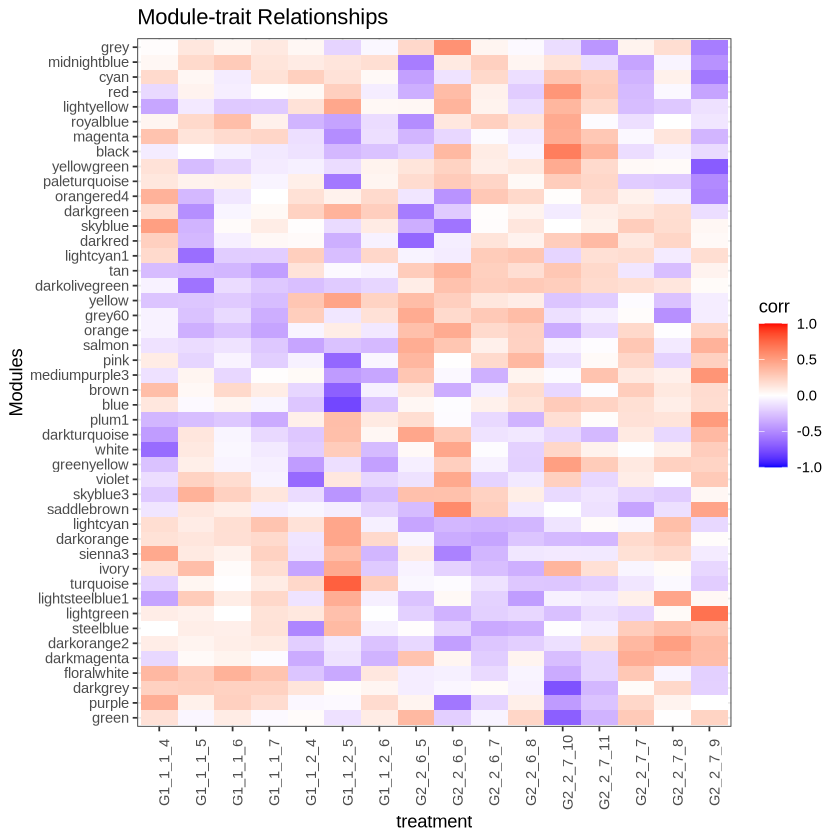

In [32]:
# tidy & plot data
mME = MEs0 %>%
  pivot_longer(-treatment) %>%
  mutate(
    name = gsub("ME", "", name),
    name = factor(name, levels = module_order)
  )

mME %>% ggplot(., aes(x=treatment, y=name, fill=value)) +
  geom_tile() +
  theme_bw() +
  scale_fill_gradient2(
    low = "blue",
    high = "red",
    mid = "white",
    midpoint = 0,
    limit = c(-1,1)) +
  theme(axis.text.x = element_text(angle=90)) +
  labs(title = "Module-trait Relationships", y = "Modules", fill="corr")

In [33]:
# Save the plot as a PDF file
ggsave("06_WGCNA/module_trait_relationships.pdf",width = 8, height = 10)